In [1]:
import numpy as np
# %matplotlib notebook
import matplotlib.pyplot as plt

import pytransform3d.plot_utils as plot_utils
from pytransform3d.plot_utils import make_3d_axis
from pytransform3d.transformations import transform_from, plot_transform

inch2m = 0.0254
adpaterplate_thickness = 1 * inch2m
tagboard_thickness = 0.125 * inch2m
Z_OFFSET_TAG_IN_BASE = -0.875 * inch2m # 1" adapter plate - 0.125" tagboard thickness

theta= np.pi / 2
opb_length = 914 / 1000
opb_width = 1524 / 1000
opb_height = 58 / 1000

R_breadboard_in_base = np.array([[np.cos(theta), np.sin(theta), 0],
								 [-np.sin(theta), np.cos(theta), 0],
								 [0, 0, 1]])

T_breadboard_in_base = np.block([np.eye(4,3) @ R_breadboard_in_base @ np.eye(3, 4) @ np.eye(4, 3), np.array([-opb_length / 2, 0, -adpaterplate_thickness, 1]).reshape(4,-1)])

def align_T_tagboard(T_tagboard_in_base):
    T_tagboard_aligned = inv_T(T_tagboard_in_base) @ T_tagboard_in_base
    R, t = T_tagboard_in_base[:3, :3], T_tagboard_in_base[:3, 3]
    t[2] = Z_OFFSET_TAG_IN_BASE
    return np.block([[R.T @ R, t.reshape(3, 1)],
                       [np.array([0, 0, 0, 1])]])

def get_ang_err(R_tag):
    # Calculate the angular difference between two rotation matrices θ = arccos((trace(R) - 1) / 2)
    ang_err = np.arccos((np.trace(np.eye(3) @ R_tag.T) - 1) / 2)
    ang_err *= 180/np.pi
    return ang_err


def inv_T(T):
    R_inv = T[:3, :3].T
    t_inv = R_inv @ T[:3, 3]
    return np.block([[R_inv, t_inv.reshape(3, 1)],
                     [np.array([0, 0, 0, 1])]])

def draw_workspace(T_camera_in_base, T_tagboard_in_base, figsize=(10,10)):
    # Visualize each frame
    plt.figure(figsize=figsize, constrained_layout=True)
    ax = make_3d_axis(1, 111, n_ticks=10, unit="m")
    ax.set_zticks([-0.3, 2])
    #ax.view_init(elev=30, azim=-70)

    T_tagboard_aligned = align_T_tagboard(T_tagboard_in_base)
    plot_transform(ax, s=0.5,  name="Robot Base")
    plot_transform(ax, s=0.5, A2B=T_camera_in_base, name="Camera in base")
    plot_transform(ax, s=0.25, A2B=T_tagboard_in_base, name="Tagboard in base")
    # plot_transform(ax, s=0.5, A2B=T_breadboard_in_base, name="Breadboard in base")
    plot_transform(ax, s=0.5, A2B=T_tagboard_aligned, name="Corrected Tagboard in base")

    # Visualize x-y planes of each frame
    plot_utils.plot_box(ax, size=np.array([0.20, 0.20, 0.00254]), A2B=T_tagboard_in_base, color="purple", wireframe=False, ax_s=0.5, alpha=0.8)
    plot_utils.plot_box(ax, size=np.array([0.205, 0.205, 0.0254]), A2B=T_tagboard_aligned, color="yellow", wireframe=False, ax_s=1, alpha=0.6)
    plot_utils.plot_box(ax, size=np.array([0.20, 0.20, 0.0254]), color="green", wireframe=False, ax_s=0.5, alpha=0.8)
    plot_utils.plot_box(ax, A2B=T_breadboard_in_base, size= np.array([opb_length, opb_width, opb_height]), color="grey", wireframe=False, alpha=0.2)
    ax.set_title("Frames in Worksace")
    ax.legend(["Tagboard", "Robot base"])

    plt.show()
    
    
def plot_plane_intersections():
    plt.figure(figsize=(16, 16), constrained_layout=True)
    ax = make_3d_axis(1, 111, n_ticks=10, unit="m")
    ang_err = get_ang_err(R_tagboard_in_base)
    print(f"Rotational Angular Error between tagboard and robot base: {ang_err:.6f}")
    print(f"Tagboard aligned to Robot base: {np.allclose(ang_err, np.zeros(0))}")
    ax = make_3d_axis(1, 132, n_ticks=10, unit="m")
    plot_utils.plot_box(ax, size=np.array([1.205, 1.205, 0.0254]), A2B=T_tagboard_in_base, color="purple", wireframe=False, ax_s=1, alpha=0.6)
    plot_utils.plot_box(ax, size=np.array([1.20,  1.20,  0.0254]), color="green", wireframe=False, ax_s=0.5, alpha=0.8)
    ax.set_title(r"$T_{tagboard}^{base}$ X-Y Plane Visualized" + f"\n" +r"$R_{tagboard}^{base}$ Angular Error w.r.t $R_{base}$: " + f"{ang_err:.6f}" + r"$\degree$")
    ax.legend(["Tagboard", "Robot base"])
    
    
    
    ang_err = get_ang_err(R_tagboard_aligned)
    print(f"Rotational Angular Error between tagboard and robot base: {ang_err:.6f}")
    print(f"Tagboard aligned to Robot base: {np.allclose(ang_err, np.zeros(0))}")
    T_tagboard_corrected_with_trans_offset = np.block([np.eye(4, 3) @ R_tagboard_aligned @ np.eye(3, 4) @ np.eye(4, 3), np.array([0, 0.5, 0, 1]).reshape(4, -1)])
    ax = make_3d_axis(1, 133, n_ticks=10, unit="m")
    T_tag_in_base = plot_utils.plot_box(ax, size=np.array([1.205, 1.205, 0.0254]), A2B=T_tagboard_corrected_with_trans_offset, color="yellow", wireframe=False, ax_s=1, alpha=0.6)
    T_base = plot_utils.plot_box(ax, size=np.array([1.20,  1.20,  0.0254]), color="green", wireframe=False, ax_s=0.5, alpha=0.8)
    ax.set_title(r"Corrected $T_{tagboard}^{base}$ X-Y Plane Visualized" + f"\n" +r"$R_{tagboard}^{base}$ Angular Error w.r.t $R_{base}$: " + f"{ang_err:.6f}" + r"$\degree$")
    ax.legend(["Tagboard", "Robot base"])
    
    # plt.tight_layout()


npz file keys:  ['0', '1', '2', '3', '4', '5']



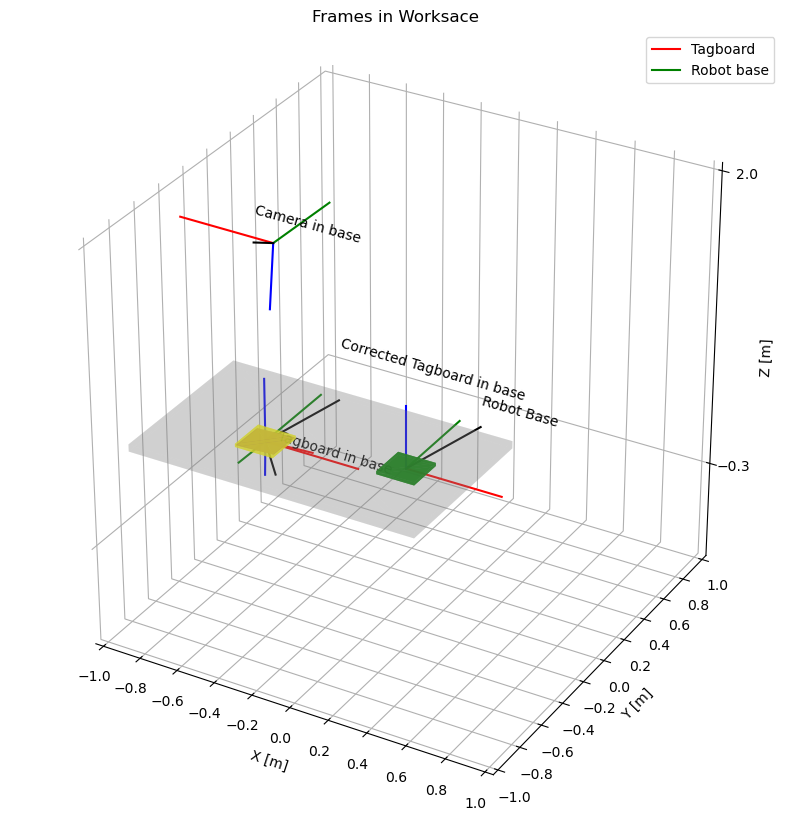

In [2]:
data_all_instances = np.load("./11_23_image_dataset/insertmold.npz", allow_pickle=True)
print("npz file keys: ", list(data_all_instances.keys()))
print()

T_tagboard_in_cam = np.load("./data/11_23_image_dataset/T_tagboard_in_cam.npy")
T_camera_in_base = np.load("./data/11_23_image_dataset/T_camera_in_base.npy")

T_base_in_cam  = np.linalg.inv(T_camera_in_base)
T_tagboard_in_base = T_camera_in_base @  T_tagboard_in_cam

draw_workspace(T_camera_in_base, T_tagboard_in_base, figsize=(8,8))


(NOT STABLE) T part in base
 [[ 0.99594 -0.09004  0.00138 -0.59716]
 [-0.08516 -0.94677 -0.31045 -0.05373]
 [ 0.02926  0.30907 -0.95059 -0.12035]
 [ 0.       0.       0.       1.     ]]
T stable part in base
 [[ 9.96195e-01 -7.96207e-02 -3.54494e-02 -5.97156e-01]
 [-8.71557e-02 -9.10069e-01 -4.05189e-01 -5.37306e-02]
 [-3.46945e-18  4.06737e-01 -9.13545e-01 -2.09250e-02]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loading instance with class: 2


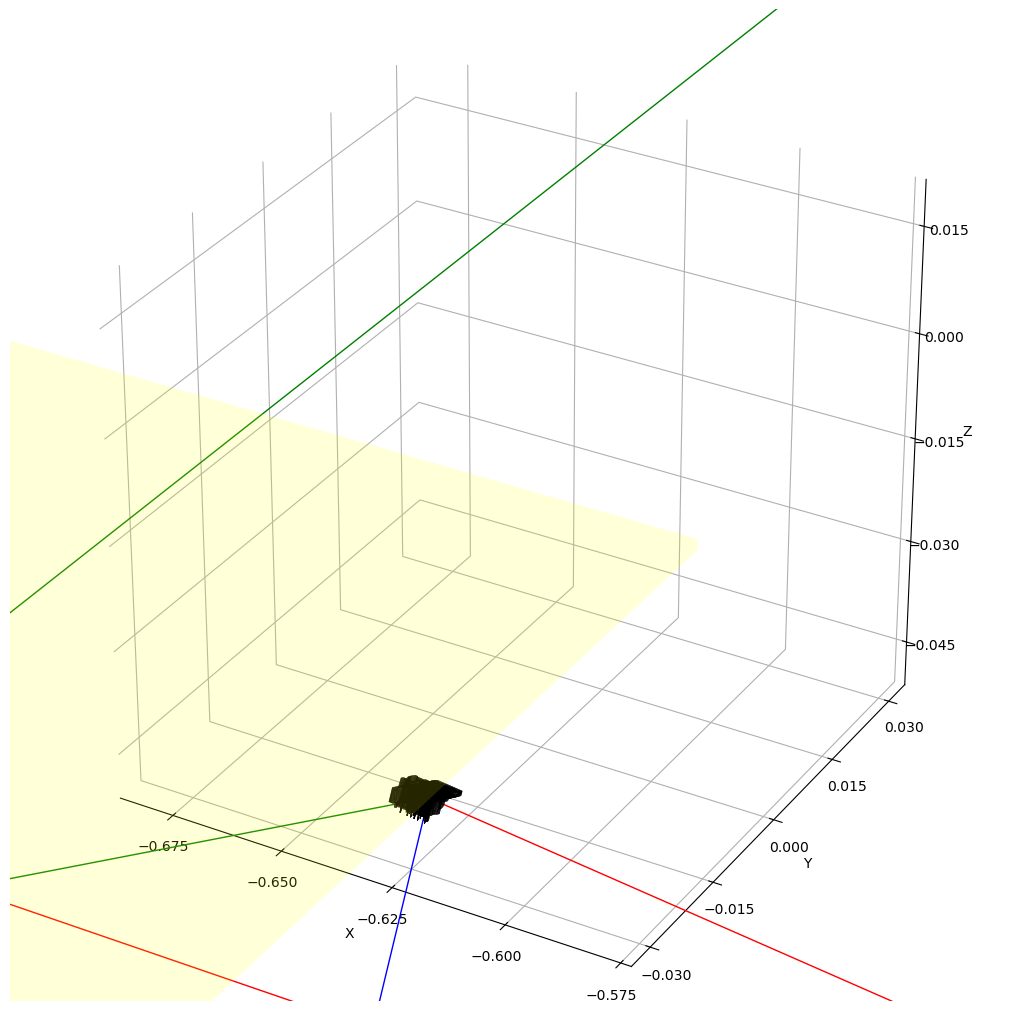

In [3]:

data_all_instances = np.load("./11_23_image_dataset/mixed.npz", allow_pickle=True)

T_tagboard_in_cam = np.load("./data/11_23_image_dataset/T_tagboard_in_cam.npy")
T_camera_in_base = np.load("./data/11_23_image_dataset/T_camera_in_base.npy")

T_base_in_cam  = np.linalg.inv(T_camera_in_base)
T_tagboard_in_base = T_camera_in_base @  T_tagboard_in_cam

# draw_workspace(T_camera_in_base, T_tagboard_in_base, figsize=(8,8))


# In[3]:

np.set_printoptions(precision=5)
# 1) Get T_part_in_base
instance_data = data_all_instances['1'].item()
cls = instance_data['class']

T_part_in_cam = instance_data['T_part_in_cam']
T_part_in_base = T_camera_in_base @ T_part_in_cam

# 2) Construct a "virtual" tagboard frame wrt robot's base

T_tag_in_base = np.eye(4)
T_tag_in_base[0, 3] = 1
T_tag_in_base[1, 3] = 1
T_tag_in_base[2, 3] = Z_OFFSET_TAG_IN_BASE

# 3) Get T_part_in_tagboard
T_part_in_tag = np.linalg.inv(T_tag_in_base) @ T_part_in_base

# 4) Get T_stable_part_in_tagboard
from mrcnn.stable_poses_est import construct_T_stable_from_T_est
R_part_in_tag = T_part_in_tag[:3, :3]
T_stable_part_in_tag = construct_T_stable_from_T_est(T_part_in_tag, instance_data['class'])

# 5) Get T_stable_part_in_base
T_stable_part_in_base = T_tag_in_base @ T_stable_part_in_tag
print(f"(NOT STABLE) T part in base\n{'='*50}\n", T_part_in_base)
np.set_printoptions(precision=5)
print(f"T stable part in base\n{'='*50}\n",T_stable_part_in_base)




paths_to_geo = ("/home/ham/GithubWorkspace/clean-pvnet/data/FIT/mainshell_test/model.ply",
                "/home/ham/GithubWorkspace/clean-pvnet/data/FIT/topshell_test/model.ply",
                "/home/ham/GithubWorkspace/clean-pvnet/data/FIT/insert_mold_test/model.ply") 

geo_path = paths_to_geo[cls]

figsize=(10,10)
plt.figure(figsize=figsize, constrained_layout=True)
ax = make_3d_axis(1, 111, n_ticks=10, unit="m")

# Set the scaling factors for the x, y, and z axes
# x = 0.8
x = [-0.68, -0.58]
y = [-0.03, 0.03]
z=0.02
# Add Geometry
T_tagboard_aligned = align_T_tagboard(T_tagboard_in_base)
# print(f"T aligned tagboard in base\n{'='*50}\n", T_tagboard_aligned)
plot_utils.plot_mesh(filename=geo_path, A2B=T_stable_part_in_base, s=np.ones(3), alpha=0.8, ax_s=0.5)
# plot_utils.plot_box(ax, size=np.array([0.20, 0.20, tagboard_thickness/2]), A2B=T_tagboard_aligned, color="yellow", wireframe=False, ax_s=0.5, alpha=0.8)
plot_utils.plot_box(ax, size=np.array([8 * inch2m, 8 * inch2m, tagboard_thickness/2]), A2B=T_tagboard_aligned, color="yellow", wireframe=False, ax_s=0.5, alpha=0.08)
# plot_utils.plot_box(ax, size=np.array([0.20, 0.20, adpaterplate_thickness/2]), color="green", wireframe=False, ax_s=0.5, alpha=0.8)

# TODO(ham)
plot_transform(ax=ax,A2B=T_stable_part_in_base, s=0.5, lw=1)
plot_transform(ax=ax, A2B=T_tagboard_aligned, s=0.5, lw=1)
# plot_transform(ax=ax, name="Robot Base",s=0.5, lw=1)
ax.autoscale()
ax.auto_scale_xyz(x, y, [-.05, z])

print(f"Loading instance with class: {cls}")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 10000)


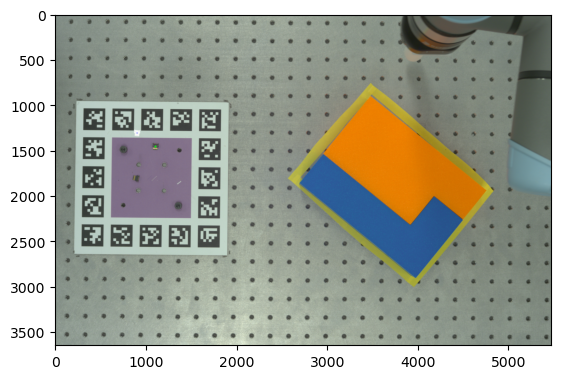

In [4]:
from open3d.geometry import TriangleMesh as tri

import mrcnn.utils.visualization  as vis
import cv2


N = 10000
def sample_points(geo_path, num_points=N):
    from open3d.io import read_triangle_mesh
    ply = read_triangle_mesh(geo_path)

    # T_opengl_inv = np.linalg.inv(np.diag([1, -1, -1, 1]))
    T_opengl_inv = np.diag([1, 1, 1, 1])
    pts = np.array(tri.sample_points_uniformly(ply, num_points).points)
    pts_h = np.block([pts, np.ones((N, 1))])
    pts_cv = T_opengl_inv @ pts_h.T
    return pts_cv / pts_cv[-1]


# Camera Intrinsics
# Instrinsics April 2023 - 25mm lens
# See https://github.com/cobot-factory/ur5e_collab_ws/blob/main/src/cobot_resources/camera/basler_25mm_intrinsics_April.28.23.yaml
camera = {
    "fx": 10704.062350, 
    "fy": 10727.438047, 
    "ox": 2694.112343, 
    "oy": 1669.169773, 
    "w": 5472, 
    "h": 3648 
}

K = np.stack([[camera['fx'], 0, camera['ox']],
              [0, camera['fy'], camera['oy']],
              [0,            0,           1]])

T_cam_in_base = np.load("/home/ham/GithubWorkspace/test_ur5e_collab/src/T_cam_in_base.npy")
T_base_in_cam = np.linalg.inv(T_cam_in_base)


pcds = [sample_points(path) for path in paths_to_geo]

# The "bad" stable pose
T_part_in_base = np.array([[ 9.94521895e-01, -9.54915028e-02, -4.25155563e-02, -4.88403045e-01],
                           [-1.04528463e-01, -9.08540960e-01, -4.04508497e-01, -8.81715026e-02],
                           [ 3.46944695e-18,  4.06736643e-01, -9.13545458e-01, -2.09250000e-02],
                           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
mrcnn_cent = np.array([1108, 1460], dtype=np.uint)

# The "good" stable pose
# T_part_in_base = np.array([[ 0.22495105, -0.97437006,  0.,         -0.4839254, ],
#                            [ 0.97437006,  0.22495105,  0.,         -0.03283633,],
#                            [ 0.        ,  0.        ,  1.,         -0.020125 , ],
#                            [ 0.        ,  0.        ,  0.,          1.       , ]])
# mrcnn_cent = np.array([897, 1812], dtype=np.uint)

def project_cad_model(T_part_in_base, pts):
    img = vis.load_img("./ros_input.png", add_alpha=False)
    
    P = K @ np.eye(3, 4) @ T_base_in_cam
    
    
    cent_p = P @ T_part_in_base[:, 3]
    cent_pix = (cent_p / cent_p[2])[:2].astype(np.uint)
    
    P_part = pts
    
    
    im_pix = P @ T_part_in_base @ P_part
    
    im_pix /= im_pix[2]
    
    ind = im_pix[:2].astype(np.uint)
    
    print(ind.reshape(2, -1).shape)
    
    img[ind[1, :], ind[0, :]] = 255
    
    img = cv2.circle(img, mrcnn_cent.tolist(), 10, (0, 255, 0), -1)
    img = cv2.circle(img, cent_pix.tolist(), 5, (0, 0, 255), -1)
    
    crop_roi = vis.crop_roi(img, cent_pix.tolist(), 128)
    return img, crop_roi


img, crop_roi = project_cad_model(T_part_in_base, pcds[2])
plt.imshow(img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


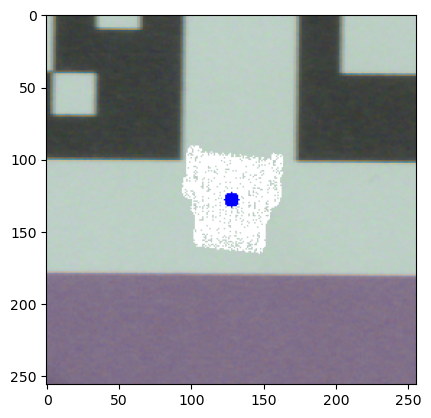

In [5]:
plt.imshow(crop_roi)

XYZ_base: [-0.514  -0.0696 -0.0199  1.    ]
[-0.4884 -0.0882 -0.0209]
[-0.514  -0.0696 -0.0209]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 10000)


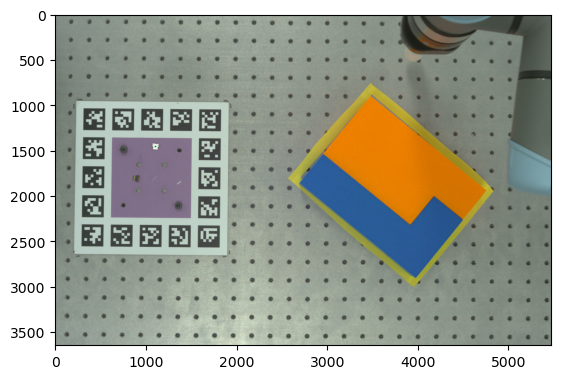

In [8]:
Z_scale = T_cam_in_base[2, 3] - T_part_in_base[2, 3] 

XYZ_cam = Z_scale * np.linalg.inv(K) @ np.array([*mrcnn_cent,1]).T 
XYZ_base = T_cam_in_base @ np.array([*XYZ_cam, 1]) 
print(f"XYZ_base: {XYZ_base}")


np.set_printoptions(precision=4)
print(T_part_in_base[:3, 3])
      
T_part_updated = T_part_in_base.copy()
T_part_updated[:2, 3] = XYZ_base[:2]
print(T_part_updated[:3, 3])
img, crop_roi = project_cad_model(T_part_updated, pcds[2])
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


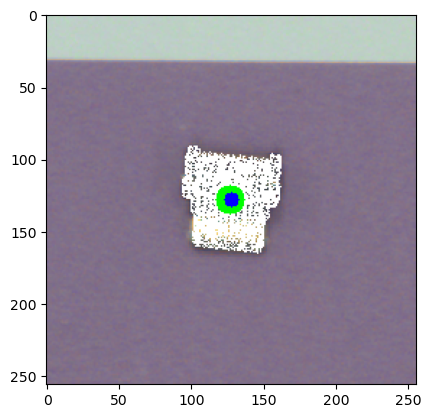

In [7]:
plt.imshow(crop_roi)